# MNIST

In [1]:
import datetime
stime = datetime.datetime.now()
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)
mnist.keys()
etime = datetime.datetime.now()
print(etime-stime)

0:00:40.662325


In [2]:
# from sklearn.datasets import fetch_mldata #0.20版本已经无法使用
# mnist = fetch_mldata('MNIST original')
# mnist

In [3]:
X,y = mnist["data"],mnist["target"]
X.shape

(70000, 784)

In [4]:
y.shape

(70000,)

In [5]:
import matplotlib as mpl
import matplotlib.pyplot as plt
some_digit = X[0]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image,cmap="binary")
plt.axis("off")
plt.show()

<Figure size 640x480 with 1 Axes>

In [6]:
y[0]

'5'

In [7]:
import numpy as np
y=y.astype(np.uint8)

In [8]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [9]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

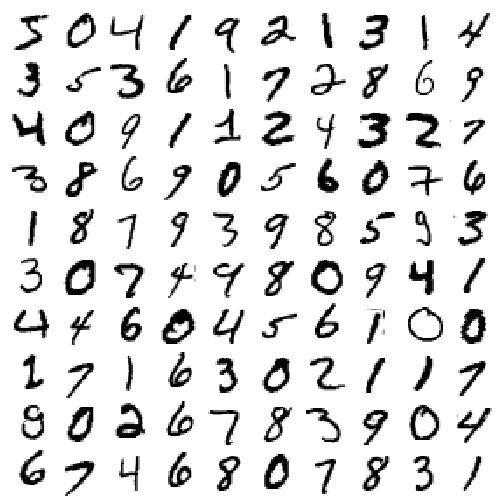

In [10]:
plt.figure(figsize=(9,9))
example_images = X[:100]
plot_digits(example_images, images_per_row=10)
#plt.savefig("more_digits_plot")
plt.show()

In [11]:
X_train,X_test,y_train,y_test=X[:60000],X[60000:],y[:60000],y[60000:]

# Training a Binary Classifier

In [12]:
y_train_5=(y_train==5)
y_test_5=(y_test==5)

In [13]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train,y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=42, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [14]:
sgd_clf.predict([some_digit])

array([ True])

# Performance Measures

In [15]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=42)

for train_index,test_index in skfolds.split(X_train,y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    clone_clf.fit(X_train_folds,y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.95035
0.96035
0.9604


In [16]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [17]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(sel,X,y=None):
        pass
    def predict(self,X):
        return np.zeros((len(X),1),dtype=bool)
    
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf,X_train,y_train_5,cv=3,scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

In [18]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)

In [19]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5,y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [20]:
y_train_perfect_predictions=y_train_5
confusion_matrix(y_train_5,y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]], dtype=int64)

In [21]:
from sklearn.metrics import precision_score,recall_score
precision_score(y_train_5,y_train_pred)

0.8370879772350012

In [22]:
recall_score(y_train_5,y_train_pred)

0.6511713705958311

In [23]:
from sklearn.metrics import f1_score
f1_score(y_train_5,y_train_pred)

0.7325171197343846

In [24]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [25]:
threshold=0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [26]:
threshold=8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [27]:
y_scores = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3,method="decision_function")
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

In [28]:
from sklearn.metrics import precision_recall_curve
precisions,recalls,thresholds=precision_recall_curve(y_train_5,y_scores)

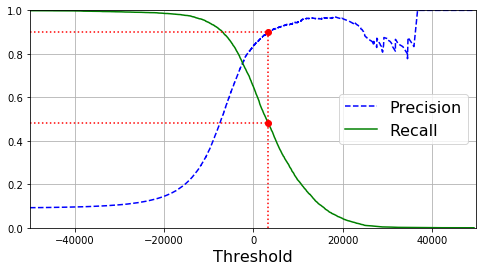

In [29]:
def plot_precision_recall_vs_threshold(presions,recall,thresholds):
    plt.plot(thresholds,precisions[:-1],"b--",label="Precision")
    plt.plot(thresholds,recalls[:-1],"g-",label="Recall")
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))                                                                  # Not shown
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")                 # Not shown
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")                                # Not shown
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")# Not shown
plt.plot([threshold_90_precision], [0.9], "ro")                                             # Not shown
plt.plot([threshold_90_precision], [recall_90_precision], "ro") 
# plt.savefig("precision_recall_vs_threshold_plot")                                              # Not shown# Not shown
plt.show()

In [30]:
threshold_90_precision=thresholds[np.argmax(precisions>=0.90)]
threshold_90_precision

3370.0194991439594

In [31]:
y_train_pred_90=(y_scores>=threshold_90_precision)
y_train_pred_90

array([False, False, False, ...,  True, False, False])

In [32]:
precision_score(y_train_5,y_train_pred_90)

0.9000345901072293

In [33]:
recall_score(y_train_5,y_train_pred_90)

0.4799852425751706

# The ROC Curve

In [34]:
from sklearn.metrics import roc_curve
fpr,tpr,thresholds=roc_curve(y_train_5,y_scores)

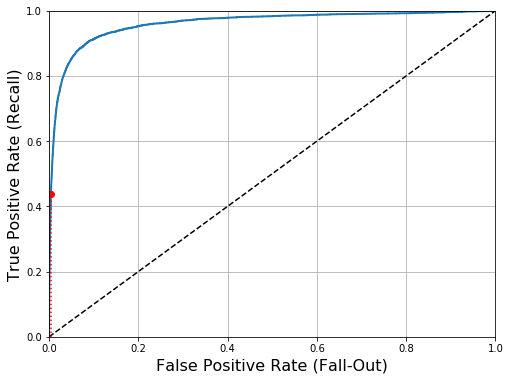

In [35]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)  
    
plt.figure(figsize=(8, 6))                         # Not shown
plot_roc_curve(fpr, tpr)
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:") # Not shown
#plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")  # Not shown
plt.plot([4.837e-3], [0.4368], "ro")               # Not shown
#save_fig("roc_curve_plot")                         # Not shown
plt.show()

In [36]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5,y_scores)

0.9604938554008616

In [37]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100,random_state=42)
y_probas_forest = cross_val_predict(forest_clf,X_train,y_train_5,cv=3,method="predict_proba")

In [38]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

In [39]:
y_scores_forest = y_probas_forest[:,1]
fpr_forest,tpr_forest,thresholds_forest=roc_curve(y_train_5,y_scores_forest)

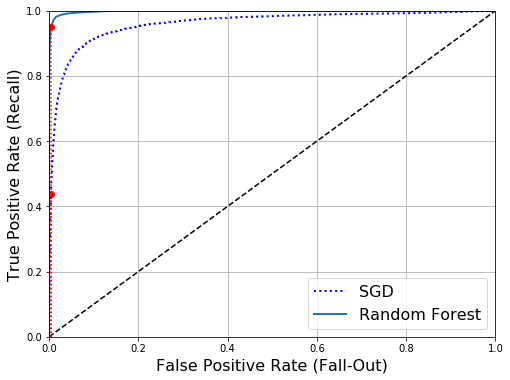

In [40]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.plot([4.837e-3, 4.837e-3], [0., 0.4368], "r:")
plt.plot([0.0, 4.837e-3], [0.4368, 0.4368], "r:")
plt.plot([4.837e-3], [0.4368], "ro")
plt.plot([4.837e-3, 4.837e-3], [0., 0.9487], "r:")
plt.plot([4.837e-3], [0.9487], "ro")
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

In [41]:
roc_auc_score(y_train_5,y_scores_forest)

0.9983436731328145

# Multiclass Classification

In [42]:
from sklearn.svm import SVC
svm_clf = SVC(gamma="auto", random_state=42)#0.22版本要设置gamma
svm_clf.fit(X_train[:1000],y_train[:1000])#全部训练时间太久了
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [43]:
some_digit_scores=svm_clf.decision_function([some_digit])
some_digit_scores

array([[ 2.81585438,  7.09167958,  3.82972099,  0.79365551,  5.8885703 ,
         9.29718395,  1.79862509,  8.10392157, -0.228207  ,  4.83753243]])

In [44]:
np.argmax(some_digit_scores)

5

In [45]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [46]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000],y_train[:1000])
ovr_clf.predict([some_digit])

array([5], dtype=uint8)

In [47]:
len(ovr_clf.estimators_)

10

In [48]:
sgd_clf.fit(X_train[:1000],y_train[:1000])
sgd_clf.predict([some_digit])

array([5], dtype=uint8)

In [49]:
sgd_clf.decision_function([some_digit])

array([[-6049581.97985829, -6138036.45541781, -3886281.38604606,
         -604692.42366776, -6948311.32017536,   914498.2913215 ,
        -6855666.78647961, -3866146.33271573, -4016434.08430155,
        -3209136.89074954]])

In [50]:
cross_val_score(sgd_clf,X_train,y_train,cv=3,scoring="accuracy")

array([0.87082583, 0.87089354, 0.88628294])

In [51]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf,X_train_scaled,y_train,cv=3,scoring="accuracy")

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([0.89957009, 0.89344467, 0.89963495])

# Error Analysis

In [52]:
y_train_pred = cross_val_predict(sgd_clf,X_train_scaled,y_train,cv=3)
conf_mx = confusion_matrix(y_train,y_train_pred)
conf_mx

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:561: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


array([[5576,    0,   21,    6,    9,   43,   37,    6,  224,    1],
       [   0, 6398,   38,   23,    4,   44,    4,    8,  213,   10],
       [  26,   27, 5242,   90,   71,   26,   62,   36,  371,    7],
       [  24,   17,  117, 5220,    2,  208,   28,   40,  405,   70],
       [  12,   14,   48,   10, 5192,   10,   36,   26,  330,  164],
       [  28,   15,   33,  166,   55, 4437,   76,   14,  538,   59],
       [  30,   14,   41,    2,   43,   95, 5560,    4,  128,    1],
       [  21,    9,   52,   27,   51,   12,    3, 5693,  188,  209],
       [  17,   63,   46,   90,    3,  125,   25,   10, 5429,   43],
       [  23,   18,   31,   66,  116,   32,    1,  179,  377, 5106]],
      dtype=int64)

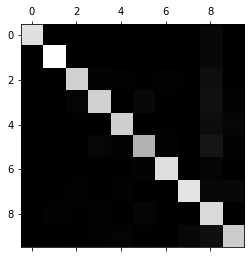

In [53]:
plt.matshow(conf_mx,cmap=plt.cm.gray)
plt.show()

In [54]:
row_sums=conf_mx.sum(axis=1,keepdims=True)
norm_conf_mx=conf_mx/row_sums

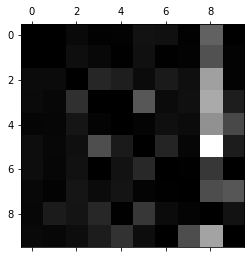

In [55]:
np.fill_diagonal(norm_conf_mx,0)
plt.matshow(norm_conf_mx,cmap=plt.cm.gray)
plt.show()

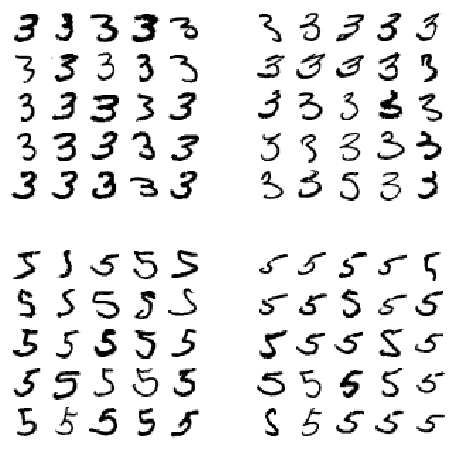

In [56]:
cl_a,cl_b=3,5
X_aa=X_train[(y_train==cl_a)&(y_train_pred==cl_a)]
X_ab=X_train[(y_train==cl_a)&(y_train_pred==cl_b)]
X_ba=X_train[(y_train==cl_b)&(y_train_pred==cl_a)]
X_bb=X_train[(y_train==cl_b)&(y_train_pred==cl_b)]
plt.figure(figsize=(8,8))
plt.subplot(221);plot_digits(X_aa[:25],images_per_row=5)
plt.subplot(222);plot_digits(X_ab[:25],images_per_row=5)
plt.subplot(223);plot_digits(X_ba[:25],images_per_row=5)
plt.subplot(224);plot_digits(X_bb[:25],images_per_row=5)
plt.show()

# Multilabel Classification

In [57]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train>=7)
y_train_odd = (y_train %2==1)
y_multilabel = np.c_[y_train_large,y_train_odd]
knn_clf =  KNeighborsClassifier()
knn_clf.fit(X_train,y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [58]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [59]:
s_time = datetime.datetime.now()
y_train_knn_pred = cross_val_predict(knn_clf,X_train,y_multilabel,cv=3)
f1_score(y_multilabel,y_train_knn_pred,average="macro")
e_time = datetime.datetime.now()
print(e_time-s_time)

0:47:04.928577


# Multioutput Classification

In [60]:
import numpy as np
noise = np.random.randint(0,100,(len(X_train),784))
X_train_mod = X_train+noise
noise = np.random.randint(0,100,(len(X_test),784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

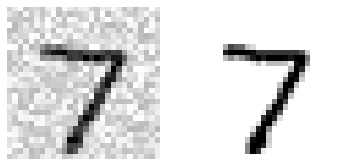

In [61]:
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
plt.show()

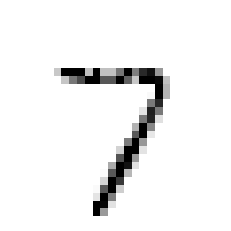

In [62]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

# Extra material

# Dummy (ie. random) classifier

- most_frequent: 预测值是出现频率最高的类别 
- stratified : 根据训练集中的频率分布给出随机预测(默认) 
- uniform: 使用等可能概率给出随机预测 
- constant: 根据用户的要求, 给出常数预测.

In [63]:
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import cross_val_predict
dmy_clf = DummyClassifier()
y_probas_dmy = cross_val_predict(dmy_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_scores_dmy = y_probas_dmy[:, 1]

0:00:00.023001


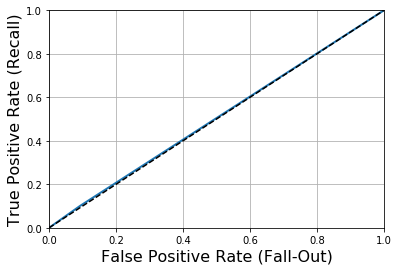

In [64]:
import datetime
stime = datetime.datetime.now()
fprr, tprr, thresholdsr = roc_curve(y_train_5, y_scores_dmy)
plot_roc_curve(fprr, tprr)
etime = datetime.datetime.now()
print(etime-stime)

# KNN classifier

In [65]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=4)
knn_clf.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [66]:
y_knn_pred = knn_clf.predict(X_test)

In [67]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test, y_knn_pred)

0.9714

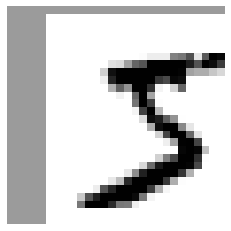

In [68]:
from scipy.ndimage.interpolation import shift
def shift_digit(digit_array, dx, dy, new=0):
    return shift(digit_array.reshape(28, 28), [dy, dx], cval=new).reshape(784)

plot_digit(shift_digit(some_digit, 5, 1, new=100))

In [69]:
X_train_expanded = [X_train]
y_train_expanded = [y_train]
for dx, dy in ((1, 0), (-1, 0), (0, 1), (0, -1)):
    shifted_images = np.apply_along_axis(shift_digit, axis=1, arr=X_train, dx=dx, dy=dy)
    X_train_expanded.append(shifted_images)
    y_train_expanded.append(y_train)

X_train_expanded = np.concatenate(X_train_expanded)
y_train_expanded = np.concatenate(y_train_expanded)
X_train_expanded.shape, y_train_expanded.shape

((300000, 784), (300000,))

In [70]:
knn_clf.fit(X_train_expanded, y_train_expanded)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [71]:
y_knn_expanded_pred = knn_clf.predict(X_test)

In [72]:
accuracy_score(y_test, y_knn_expanded_pred)

0.9763

In [73]:
ambiguous_digit = X_test[2589]
knn_clf.predict_proba([ambiguous_digit])

array([[0.24579675, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.75420325]])

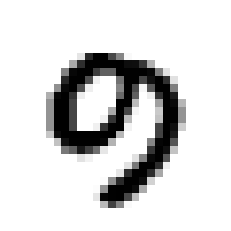

In [74]:
plot_digit(ambiguous_digit)